# Load Balancer Performance Analysis
This notebook provides insights on the performance of the implemented load balancer.

## Required Libraries

In [4]:
# Asynchronous requests handling
import asyncio
import aiohttp

# Frequency counter
from collections import Counter

# For random operations - such as random request IDs
import random

# Visualization
import matplotlib.pyplot as plt

# For creating the consistent hash ring
from consistent_hash import ConsistentHashRing

## Constants

In [6]:
NUM_REQUESTS = 10000 # Number of async requests to be executed

## A-1: Requests Count Per Server Instance
- This experiment involves executing 10,000 async requests on the 3 server containers.
- Requests count are displayed in a bar chart.

### Asynchronous launching of 10,000 requests
- The launching of 10,000 is achieved by using the AIOHTTP Python library, which enables for asynchronous HTTP client/server communications.
- It is built on top of asyncio, which handles non-blocking I/O operations, allowing for concurrency.

In [1]:
URL = "http://localhost:5000/home"

async def fetch(session, url=URL):
    """Gets a response from the server URL, returning the server id."""
    try:
        async with session.get(url) as response:
            data = await response.json()
            message = data.get("message", "")
            server_id = message.split()[-1].split(":")[0]
            return server_id
    except Exception as e:
        print(f"Error fetching {url}: {e}")
        return None


async def count_requests_per_server():
    """Counts the number of requests handled by each server."""
    counter = Counter()
    async with aiohttp.ClientSession() as session:
        tasks = [fetch(session, url=URL) for _ in range(NUM_REQUESTS)]
        results = await asyncio.gather(*tasks)
        for server in results:
            if server is not None:
                counter[server] += 1

    return counter

### Requests Distribution Bar Chart

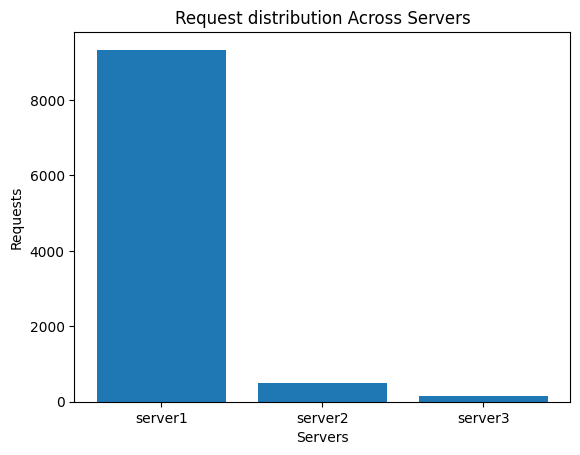

In [4]:
async def show_requests_distribution():
    """Plots a bar chart showing the number of requests per server."""
    requests_count = await count_requests_per_server()
    servers = sorted(requests_count.keys())
    counts = list(requests_count.values())

    plt.bar(servers, counts)
    plt.title("Request distribution Across Servers")
    plt.xlabel("Servers")
    plt.ylabel("Requests")
    plt.show()

await show_requests_distribution()

### Observations
From the graph, most of the requests (more than 90%) are handled by server1, with the rest handling a fairly even number of requests. This may be caused by the hash function mapping requests to servers, which may be returning hash values that direct requests to server1. This represents an imbalance in the number of requests handled across the 3 servers, as server1 handles a large number of requests, leaving the rest of the servers under-utilised.

## A-2: Average Load of Servers for N = 2 to 6

- This experiment involves iteratively increasing the number of servers from 2 to 6 while launching async requests.

In [2]:
SERVER_RANGE = range(2, 7)
AVERAGES = []

async def fetch_server(ring):
    """Gets the server for a particular request."""
    request_id = random.randint(100000, 999999)
    server = ring.get_server_for_request(request_id)
    return server


async def run_simulation(num_servers):
    """Creates a hash ring and simulates async requests for a set number of servers."""
    servers = [f"server{i + 1}:5000" for i in range(num_servers)]
    ring = ConsistentHashRing(servers=servers, slots=512, virtual_nodes=9)
    counter = Counter()

    # Count requests per server
    async with aiohttp.ClientSession() as session:
        tasks = [fetch_server(ring) for _ in range(NUM_REQUESTS)]
        results = await asyncio.gather(*tasks)
        for server in results:
            counter[server] += 1

    loads = list(counter.values())
    avg_load = sum(loads) / num_servers
    return avg_load

## A Line Chart Showing Average Load against No. of Servers

N=2, Avg load: 5000.00
N=3, Avg load: 3333.33
N=4, Avg load: 2500.00
N=5, Avg load: 2000.00
N=6, Avg load: 1666.67


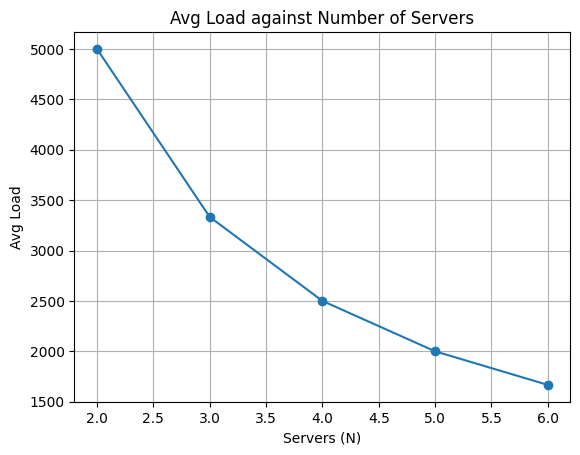

In [6]:
async def show_average_load():
    """Plots the average load against number of servers N."""
    for N in SERVER_RANGE:
        avg = await run_simulation(N)
        print(f"N={N}, Avg load: {avg:.2f}")
        AVERAGES.append(avg)

    plt.plot(list(SERVER_RANGE), AVERAGES, marker='o')
    plt.title("Avg Load against Number of Servers")
    plt.xlabel("Servers (N)")
    plt.ylabel("Avg Load")
    plt.grid()
    plt.show()

await show_average_load()

### Observations
From the line chart, the average number of requests being handled per server is inversely proportional to the number of servers being handled by the load balancer. This behaviour is expected because more servers means fewer requests routed to a specific server, showing a case of horizontal scaling.

## A-3: Failure Detection and Handling
- This experiment analyses how the load balancer handles server failures.

### Testing the Load Balancer Endpoints

In [7]:
# Requests module
import requests

### 1. GET `/rep`

In [9]:
response = requests.get("http://localhost:5000/rep")
print(f"Status Code: {response.status_code}")
print(response.json())

Status Code: 200
{'message': {'N': 3, 'replicas': ['server1:5000', 'server2:5000', 'server3:5000'], 'status': 'successful'}}


### 2. POST `/add`

In [18]:
payload = {
    "n" : 2,
    "hostnames" : ["S5", "S8"]
}

response = requests.post("http://localhost:5000/add", json=payload)
print(f"Status Code: {response.status_code}")
print(response.json())

Status Code: 200
{'message': {'N': 5, 'replicas': ['server1:5000', 'server2:5000', 'server3:5000', 'S5', 'S8'], 'status': 'successful'}}


### 3. DELETE `/rm`

In [19]:
payload = {
    "n" : 2,
    "hostnames" : ["S5", "S8"]
}

response = requests.delete("http://localhost:5000/rm", json=payload)
print(f"Status Code: {response.status_code}")
print(response.json())

Status Code: 200
{'message': {'N': 3, 'replicas': ['server1:5000', 'server2:5000', 'server3:5000'], 'status': 'successful'}}


### 4. Invalid path

In [60]:
response = requests.get("http://localhost:5000/other")
print(f"Status Code: {response.status_code}")
print(response.json())

Status Code: 400
{'message': "Error: 'other' endpoint not supported", 'status': 'failure'}


### Testing Failure of One Server
- Launching 10 requests to the `/home` endpoint:

In [84]:
for _ in range(10):
    try:
        response = requests.get("http://localhost:5000/home", timeout=2)
        print(response.status_code, response.json())
    except requests.exceptions.RequestException as e:
        print("Request failed:", e)

200 {'message': 'Hello from Server: server1', 'status': 'successful'}
200 {'message': 'Hello from Server: server3', 'status': 'successful'}
200 {'message': 'Hello from Server: server1', 'status': 'successful'}
200 {'message': 'Hello from Server: server1', 'status': 'successful'}
200 {'message': 'Hello from Server: server1', 'status': 'successful'}
200 {'message': 'Hello from Server: server1', 'status': 'successful'}
200 {'message': 'Hello from Server: server1', 'status': 'successful'}
200 {'message': 'Hello from Server: server1', 'status': 'successful'}
200 {'message': 'Hello from Server: server1', 'status': 'successful'}
200 {'message': 'Hello from Server: server1', 'status': 'successful'}


- Stopping `server1` from running to simulate some sort of failure:

In [85]:
import subprocess
server_container = "task_3-server1-1"
try:
    subprocess.run(["docker", "stop", server_container])
    print(f"Container stopped: {server_container}")
except subprocess.CalledProcessError as e:
    print(f"Failed to stop container {server_container}: {e}")

task_3-server1-1
Container stopped: task_3-server1-1


- Request routing after server failure:

In [119]:
for _ in range(10):
    try:
        response = requests.get("http://localhost:5000/home", timeout=2)
        print(response.status_code, response.json())
    except requests.exceptions.RequestException as e:
        print("Request failed:", e)

200 {'message': 'Hello from Server: server3', 'status': 'successful'}
200 {'message': 'Hello from Server: server2', 'status': 'successful'}
200 {'message': 'Hello from Server: server2', 'status': 'successful'}
200 {'message': 'Hello from Server: server2', 'status': 'successful'}
200 {'message': 'Hello from Server: server2', 'status': 'successful'}
200 {'message': 'Hello from Server: server2', 'status': 'successful'}
200 {'message': 'Hello from Server: server2', 'status': 'successful'}
200 {'message': 'Hello from Server: server2', 'status': 'successful'}
200 {'message': 'Hello from Server: server2', 'status': 'successful'}
200 {'message': 'Hello from Server: server2', 'status': 'successful'}


## A-4: Impact of Hash Function Modification on Request Count and Average Load Per Server

- For this experiment, the hash functions are modified, and the impact on the requests count and average load per server is analysed.

The new hash functions for the requests and servers to be used:
- Request Hash Function: $\quad H(i) = (3 \cdot i) \mod S$
- Server Hash Function: $\quad \phi(i, j) = (i^2 + 4 \cdot j) \mod S$

Where:
\begin{align*}
i & : \text{Request or Server index} \\
j & : \text{Replica index (virtual node)} \\
S & : \text{Total number of hash slots in the ring}
\end{align*}


- Programatically, these methods will be modified in the `ConsistentHashRing` class:

In [120]:
def H(self, i):
    """Returns the slot to which the request is routed."""
    hash_value = i * 3 # Modified request hash function
    return hash_value % self.slots

def Phi(self, i, j):
    """Returns the slot to which the server is located."""
    key = f"{i}-{j}"
    hash_value = (i**2) + (j*4) # Modified server hash function
    return hash_value % self.slots


## Requests Distribution Bar Chart

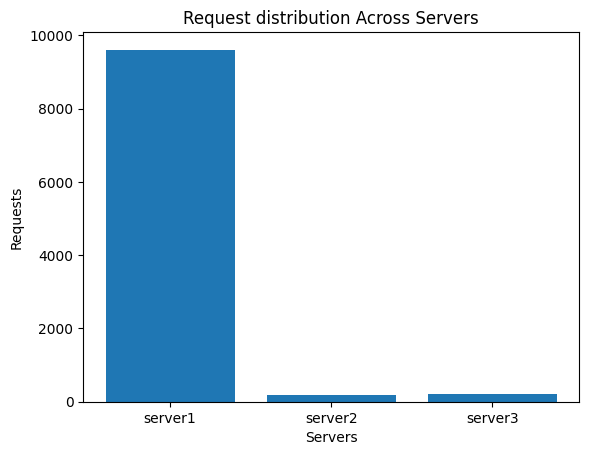

In [123]:
async def show_requests_distribution():
    """Plots a bar chart showing the number of requests per server."""
    requests_count = await count_requests_per_server()
    servers = sorted(requests_count.keys())
    counts = list(requests_count.values())

    plt.bar(servers, counts)
    plt.title("Request distribution Across Servers")
    plt.xlabel("Servers")
    plt.ylabel("Requests")
    plt.show()

await show_requests_distribution()

## Average Load against No. of Servers Line Chart

N=2, Avg load: 5000.00
N=3, Avg load: 3333.33
N=4, Avg load: 2500.00
N=5, Avg load: 2000.00
N=6, Avg load: 1666.67


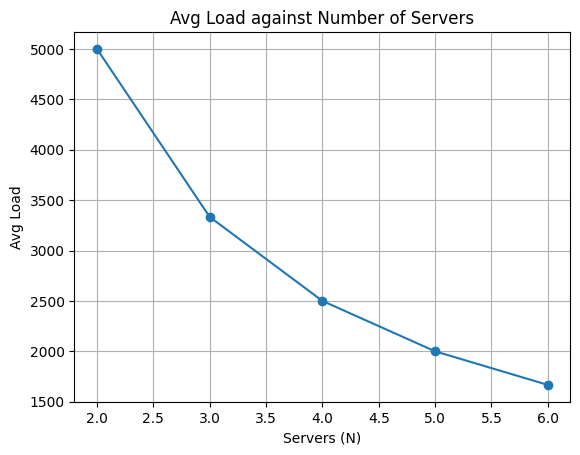

In [7]:
async def show_average_load():
    """Plots the average load against number of servers N."""
    for N in SERVER_RANGE:
        avg = await run_simulation(N)
        print(f"N={N}, Avg load: {avg:.2f}")
        AVERAGES.append(avg)

    plt.plot(list(SERVER_RANGE), AVERAGES, marker='o')
    plt.title("Avg Load against Number of Servers")
    plt.xlabel("Servers (N)")
    plt.ylabel("Avg Load")
    plt.grid()
    plt.show()

await show_average_load()